# Layer Target

This example demonstrates how to simulate the passage of a collinear beam of photons through a target that consists of several layers.
The case study is a nuclear resonance fluorescence (NRF) experiment whose goal is to measure the width of the $2^+_1$ state of the isotope $^{116}$Sn relative to the known width of the $2^+_1$ state of $^{112}$Sn.

The formalism in this notebook is based on the nice overview in C. Romig's thesis:

C. Romig, Dissertation, Technische Universität Darmstadt, Darmstadt (2015) https://tuprints.ulb.tu-darmstadt.de/id/eprint/4446

That text, in turn, is based on the diploma thesis of N. Pietralla (which is not available publicly in digital form, unfortunately):

N. Pietralla, Diplomarbeit, Universität zu Köln, Köln (1993)

## Target

The target consists of 4 stacked layers that contain enriched metallic tin material at standard conditions.
They will be numbered with roman numerals from $t=$I to $t=$IV starting with the layer that is hit first by the beam. 
The first (I) and the third (III) layer have a high enrichment $x(^{116}\mathrm{Sn})$ in the isotope $^{116}$Sn, while the second (II) and fourth (IV) layer mainly consist of $^{112}$Sn.
All targets are cylindrical with a radius of 0.5 cm.
Using the target cross section area, the areal particle density $\rho_a (t)$ (number of target nuclei per unit area, here in units of inverse femtometers squared) is calculated below.

For the description of the passage of the beam through the target, $\rho_a$ will be used instead of the $z$ coordinate (the beam propagates in the positive $z$ direction), because the target layers are assumed to be homogenous with a constant volume density $\rho$:

$\rho_a = \rho z$.

In the code, $^{112}$Sn and $^{116}$Sn are represented by two `Isotope` objects that contain information about their masses, and their ground- and excited states.
States are represented by `GroundState` and `State` objects.
The module `ries.constituents.element` provides natural-element properties, in particular isotope masses, and the code below shows how to access them.

No compilation like this exists for the known excited states of all isotopes, so the spectroscopic data entered below were looked up by hand in the Evaluated Nuclear Structure Data File (ENSDF, https://www.nndc.bnl.gov/ensdf/).

In [3]:
import numpy as np

from scipy.constants import physical_constants

from ries.constituents.isotope import Isotope
from ries.constituents.state import GroundState, State
from ries.constituents.element import natural_elements

# Remember the MeV fm K unit conventions of ries!

half_life_to_lifetime = 1./np.log(2.)

sn112 = Isotope('112Sn',
        natural_elements['Sn'].isotopes['112Sn'].amu,
        ground_state=GroundState('0^+_1', two_J=0, parity=1),
        excited_states={
            '2^+_1': State(
                '2^+_1', two_J=4, parity=1, 
                excitation_energy=1.25669,
                partial_widths={'0^+_1': physical_constants['reduced Planck constant in eV s'][0]/(0.376e-12*half_life_to_lifetime)*1e-6} # Conversion from half life to width
            )
        }
       )

sn112_enrichment = 0.951
# The following calculation for the number of nuclei in the target layer is an approximation. 
# More than 90% of the layer consist of 112Sn,
# but one would actually have to divide by the abundance-weighted average mass of all tin isotopes 
# in the sample.
sn112_II_areal_density = 2.40403e-3/(sn112.amu*physical_constants['atomic mass constant'][0])/(np.pi*0.005e15**2)
sn112_IV_areal_density = 2.39414e-3/(sn112.amu*physical_constants['atomic mass constant'][0])/(np.pi*0.005e15**2)


sn116 = Isotope('116Sn',
        natural_elements['Sn'].isotopes['116Sn'].amu,
        ground_state=GroundState('0^+_1', two_J=0, parity=1),
        excited_states={
            '2^+_1': State(
                '2^+_1', two_J=4, parity=1, 
                excitation_energy=1.293560,
                partial_widths={'0^+_1': physical_constants['reduced Planck constant in eV s'][0]/(0.374e-12*half_life_to_lifetime)*1e-6} # Conversion from half life to width
            )
        }
       )

sn116_enrichment = 0.978
sn116_I_areal_density = 2.40668e-3/(sn116.amu*physical_constants['atomic mass constant'][0])/(np.pi*0.005e15**2)
sn116_III_areal_density = 2.39617e-3/(sn116.amu*physical_constants['atomic mass constant'][0])/(np.pi*0.005e15**2)

## Cross sections

### Resonances

The cross sections $\sigma_{0^+_1 \to 2^+_1} (E; ^A\mathrm{Sn})$ for the excitation of the $2^+_1$ states of the Sn isotopes by photons are Breit-Wigner resonances, since both can be considered isolated resonances.
At standard conditions, the resonances are considerably Doppler-broadened.
Their energy dependence is given by a Voigt profile, which is the convolution of a Breit-Wigner resonance with a Maxwell-Boltzmann distribution of atom velocities.
They are modeled by `Voigt` objects, which use some of the isotope properties defined above.

A Maxwell-Boltzmann distribution can only be used for solid tin if the temperature in the Maxwell-Boltzmann distribution is replaced by an effective temperature.
To obtain this quantity, the Debye approximation is used here.
The module `ries.resonance.debye_model` provides a dictionary of room-temperature material constants ('Debye temperatures') that are needed to calculate the effective temperature for a given room temperature.
Note that the Debye temperatures in the dictionary are actually valid for elements with a natural composition of isotopes, so this is an approximation.

In [4]:
from ries.resonance.voigt import Voigt
from ries.resonance.debye_model import effective_temperature_debye_approximation, room_temperature_T_D

room_temperature = 293.

sigma_112 = Voigt(
    initial_state=sn112.ground_state,
    intermediate_state=sn112.excited_states['2^+_1'],
    amu=sn112.amu,
    effective_temperature=effective_temperature_debye_approximation(room_temperature, room_temperature_T_D['Sn']),
)

sigma_116 = Voigt(
    initial_state=sn116.ground_state,
    intermediate_state=sn116.excited_states['2^+_1'],
    amu=sn116.amu,
    effective_temperature=effective_temperature_debye_approximation(room_temperature, room_temperature_T_D['Sn']),
)

Plot the cross section for $^{116}$Sn. Note that both Sn isotopes have similar properties, so the plots for the other isotope would similar.

The `Voigt` class provides a method `equidistant_probability_grid` that partitions the energy range into quantiles of equal size.
Compared to an equidistant partition, this has the advantage that the grid is more dense around the peak and less dense at the tails where the shape does not change much and only a small fraction of the total probability is located.
For a given number of points, this should increase the precision.
A Voigt distribution is actually defined on the interval $]-\infty, \infty[$, but the energy grid is restricted to a finite symmetric coverage interval here.

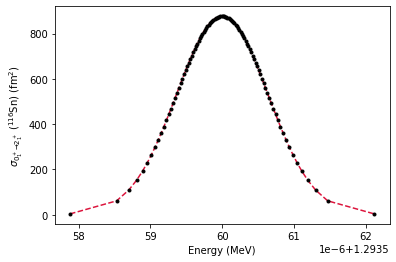

In [5]:
import matplotlib.pyplot as plt

energy_plot = sigma_116.equidistant_probability_grid(0.999, 100) # 99.9% coverage, 200 points at which the cross section is evaluated for plotting.
sigma_plot = sigma_116(energy_plot)

fig, ax = plt.subplots(1,1)
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel(r'$\sigma_{0^+_1 \to 2^+_1}$ ($^{116}$Sn) (fm$^2$)')
ax.plot(energy_plot, sigma_plot, '--', color='crimson')
ax.plot(energy_plot, sigma_plot, '.', color='black')

### Nonresonant processes

Photons will not only undergo resonant reactions in the target, but they can also be Compton-scattered, create an electron-positron pair, ...
The energy dependence of these nonresonant processes can be described by the tabulated x-ray mass attenuation coefficients (XRMAC) $\mu / \rho$ of Hubbell and Seltzer.
The module `ries.nonresonant.xrmac` provides a dictionary of all XRMACs in that database.
While the XRMACs are tabulated as *cross sections per gram*, the ones in `ries.nonresonant.xrmac.xrmac_fm2_per_atom` have already been converted to *cross sections per atom* $\sigma_\mathrm{nr}$, i.e. they are directly comparable to $\sigma_{0^+_1 \rightarrow 2^+_1}$.
Like the Debye temperatures, the XRMACs for the two enriched targets are approximated by the one for natural tin.

In [6]:
from ries.nonresonant.xrmac import xrmac_fm2_per_atom

sigma_nr = xrmac_fm2_per_atom['Sn']

/home/udo/.local/lib/python3.8/site-packages/ries-0.2.0-py3.8.egg/ries/nonresonant/xrmac.py:166: RuntimeWarning: divide by zero encountered in log10
  np.log10(data[:, 1]),
/home/udo/.local/lib/python3.8/site-packages/ries-0.2.0-py3.8.egg/ries/nonresonant/xrmac.py:168: RuntimeWarning: divide by zero encountered in log10
  fill_value=(np.log10(data[0][1]), np.log10(data[-1][1])),


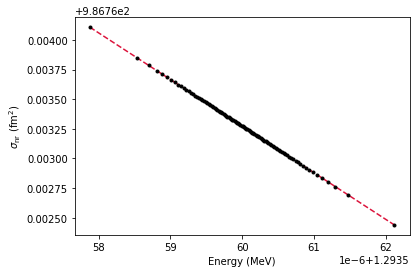

In [7]:
sigma_nr_plot = sigma_nr(energy_plot) # Plot on the same energy grid as the resonances.

fig, ax = plt.subplots(1,1)
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel(r'$\sigma_\mathrm{nr}$ (fm$^2$)')
ax.plot(energy_plot, sigma_nr_plot, '--', color='crimson')
ax.plot(energy_plot, sigma_nr_plot, '.', color='black')

## Photon flux

The dependence of the energy-differential photon flux $\mathrm{d} F / \mathrm{d} E$ (number of photons incident per energy unit, unit area and time interval [1], sometimes simply denoted as 'photon flux') on the areal density $\rho_a$ (remember that the areal density is used instead of the $z$ coordinate) into the target is given by the differential equation:

$\frac{\mathrm{d} F}{\mathrm{d} E \mathrm{d} \rho_a} (E, \rho_a) = -[\sigma_\mathrm{nr} (E) + x(^{A}\mathrm{Sn}) \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^{A}\mathrm{Sn})] \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_a)$.

Note that the NRF cross section needs to be multiplied by the abundance of the isotope, to be able to use the areal density from above (the areal density gives the number of nuclei of *any* isotope per unit area).
Since the two excited states of $^{112}$Sn and $^{116}$Sn are sufficiently far apart, only a single resonance is considered here.
In the following, the boundaries between the target layers will be denoted as $\rho_{a,i}$.
The point on the $\rho_a$ axis where the beam hits the target first is $\rho_{a,0} \equiv 0$, the point where the target exits the target is $\rho_{a,IV}$.

[1] This is the general definition of a 'flux', i.e. amount of substance per unit area and time interval. In the NRF context, the time information is often omitted, because the observed spectra represent an integration with respect to time, and the flux can usually be assumed to be constant.

In [8]:
rho_0   = 0.
rho_I   = rho_0   + sn116_I_areal_density
rho_II  = rho_I   + sn112_II_areal_density
rho_III = rho_II  + sn116_III_areal_density
rho_IV  = rho_III + sn112_IV_areal_density

The solution of the differential equation above inside a target layer $t$ is an exponential decay:

$\frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_a) = \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a,t-1}) \underbrace{\exp \{ -[\sigma_\mathrm{nr} (E) + x(^{A}\mathrm{Sn}) \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^{A}\mathrm{Sn})] (\rho_a - \rho_{a,t-1}) \}}_{\Phi_t (E, \rho_a - \rho_{a,t-1})}$

for

$\rho_{a, t-1} \leq \rho_a < \rho_{a, t-1}$.


The exponential term in this expression is sometimes called the 'photon-flux density' $\Phi_t (E, \rho_a - \rho_{a,t-1})$, as indicated in the equation above.
This quantity, in the given paramterization, is advantageous when dealing with a multi-layer target, because the attenuation of the photon flux by each target can be taken into account by a multiplicative factor.
For example, the photon flux in the second target layer can be expressed as:

$\frac{\mathrm{d} F}{\mathrm{d} E} \left( E, \rho_a \right) = \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a,0}) \exp \{ -[\sigma_\mathrm{nr} (E) + x(^{116}\mathrm{Sn}) \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^{116}\mathrm{Sn})] (\rho_{a, I} - \rho_{a, 0}) \} \exp \{ -[\sigma_\mathrm{nr} (E) + x(^{112}\mathrm{Sn}) \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^{112}\mathrm{Sn})] (\rho_{a, II} - \rho_{a, I}) \}$

$= \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a,0}) \Phi_{I} (E, \rho_{a, I} - \rho_{a, 0}) \Phi_{II} (E, \rho_{a} - \rho_{a, I})$

For a thin target or small cross sections, i.e. if

$\left[ \sigma_\mathrm{nr} (E) + x(^{A}\mathrm{Sn}) \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^{A}\mathrm{Sn}) \right] \left( \rho_{a,t} - \rho_{a,t-1} \right) \ll 1$,

holds within the energy range of interest, the variation of the photon flux with the penetration depth is negligible:

$\frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a}) \approx \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a, t-1}) \underbrace{\Phi_t (E, 0)}_{= 1}$

The functional dependence of the photon-flux density is implemented as python code below.
It was decided to keep the code as simple and explicit as possible.
It could also have been implemented as a class with a `__call__` method to avoid typing the same recurring arguments.

In [9]:
def Phi(E, rho, sigma_nr, sigma_r, abundance=1.):
    r"""Energy- and areal-density dependence of the photon-flux density

    It is assumed that the reduction of the photon flux is due to nonresonant scattering by the
    entire target material and the absorption is due to  resonances of a single isotope, whose 
    abundance can be given as an argument.

    Parameters:

    - `E`, float or array_like, energy in MeV.
    - `rho`, float or array_like, areal density in fm^-2.
    - `sigma_nr` and `sigma_r`, callable, energy-dependent nonresonant (nr) and resonant (r) cross sections in fm^2.
    - `abundance`, float, abundance of the isotope to which the resonances belong. 
Should be a number between 0 and 1 (default: 1, i.e. a monoisotopic material).

    Returns:

    - float or array_like, photon-flux density (dimensionless).
    """
    return np.exp(-(sigma_nr(E)+abundance*sigma_r(E))*rho)

Plot the energy-differential photon flux for different penetration depths into the first target layer.
Since the incident photon flux can always be factored out, the label on the y-axis is given as 'arbitrary units'.

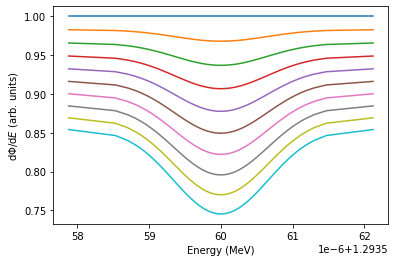

In [10]:
Phi_plot = [Phi(energy_plot, rho, sigma_nr, sigma_116, abundance=sn116_enrichment) for rho in np.linspace(0., sn116_I_areal_density, 10)]

fig, ax = plt.subplots(1,1)
ax.set_xlabel('Energy (MeV)')
ax.set_ylabel('$\mathrm{d} \Phi / \mathrm{d} E$ (arb. units)')
for phi in Phi_plot:
    ax.plot(energy_plot, phi)

## Reaction rate

The energy- and areal-density differential NRF reaction rate $\mathrm{d} N_{\mathrm{NRF},t} (^A\mathrm{Sn}) / \mathrm{d} E \mathrm{d} \rho_{a}$ in a single target layer $t$ is given by the product of the cross section, the energy-differential photon flux, and the target area $A$:

$\frac{\mathrm{d} N_{\mathrm{NRF}, t}}{\mathrm{d} E \mathrm{d} \rho_a}  (E, \rho_a, ^A\mathrm{Sn}) = x(^{A}\mathrm{Sn}) \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^A\mathrm{Sn}) \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_a) A \equiv \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a,t-1}) \alpha_t (E, \rho_a - \rho_{a, t-1}; ^A\mathrm{Sn}) A$

When normalized by dividing by the incident photon flux $\mathrm{d} F / \mathrm{d} E (E, \rho_{a,t-1})$ and the target area $A$, this quantity is sometimes called the 'resonance absorption density' and denoted as $\alpha$, as indicated by the second equality.

By integrating the expression above over the energy and the extent of the target layer, one obtains the reaction rate in this layer:

$N_{\mathrm{NRF}, t} (^A\mathrm{Sn}) = x(^{A}\mathrm{Sn}) A \int_{-\infty}^{\infty} \int_{\rho_{a,t-1}}^{\rho_{a,t}} \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^A\mathrm{Sn}) \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_a) \mathrm{d} \rho_a \mathrm{d} E$

For a thin target, the photon flux is constant inside the target, and the integral evaluates to:

$N_{\mathrm{NRF},t} (^A\mathrm{Sn}) \approx x(^{A}\mathrm{Sn}) A \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a,t-1}) \int_{-\infty}^{\infty} \int_{\rho_{a,t-1}}^{\rho_{a,t}} \sigma_{0^+_1 \rightarrow 2^+_1} (E; ^A\mathrm{Sn}) \mathrm{d} \rho_a \mathrm{d} E = \underbrace{ x(^{A}\mathrm{Sn}) A (\rho_{a,t} - \rho_{a,t-1})}_{N_t} \frac{\mathrm{d} F}{\mathrm{d} E} (E, \rho_{a,t-1}) I_{0^+_1 \rightarrow 2^+_1} (^A\mathrm{Sn})$,

i.e. the count rate is given by the product of, the number of nuclei in the target ($N_t$), the incident photon flux, and the energy-integrated cross section $I_{0^+_1 \rightarrow 2^+_1} (^A\mathrm{Sn})$.

The functional dependence of the resonance absorption density is implemented as python code below.

In [11]:
def alpha(E, rho, sigma_nr, sigma_r, abundance=1.):
    r"""Energy- and areal-density dependence of the resonance absorption density

    See also `Phi`.

    Returns:

    - float or array_like, resonance absorption density in fm^2.
    """
    return abundance*sigma_r(E)*Phi(E, rho, sigma_nr, sigma_r, abundance)

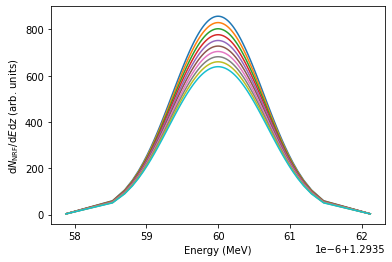

In [12]:
alpha_plot = [alpha(energy_plot, z, sigma_nr, sigma_116, sn116_enrichment) for z in np.linspace(0., sn116_I_areal_density, 10)]

fig, ax = plt.subplots(1,1)
for a in alpha_plot:
    ax.set_xlabel('Energy (MeV)')
    ax.set_ylabel(r'$\mathrm{d} N_\mathrm{NRF} / \mathrm{d} E \mathrm{d} z$ (arb. units)')
    ax.plot(energy_plot, a)

### Single Layer

In order to perform the 2D integration for the reaction rate, `scipy.integrate.nquad` is used here.
As a simple example, the code below compares the count rate to the one obtained with the thin-target approximation for different target thicknesses (the target area $A$ and the incident photon flux are set to 1).

In [13]:
from scipy.integrate import nquad

areal_densities = np.linspace(0., sn116_I_areal_density, 20)

count_rates = [
    nquad(
        lambda E, rho: alpha(E, rho, sigma_nr, sigma_116, sn116_enrichment),
        [
            [energy_plot[0], energy_plot[-1]],
            [0., r]
        ]
    )[0]
    for r in areal_densities
]
count_rates_thin_target = [
    nquad(
        lambda E, rho: alpha(E, 0., sigma_nr, sigma_116, sn116_enrichment), # Obtain thin-target approximation by making alpha independent of rho.
        [
            [energy_plot[0], energy_plot[-1]],
            [0., r]
        ]
    )[0]
    for r in areal_densities
]

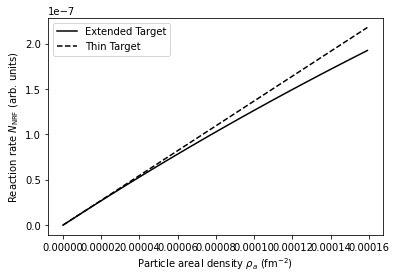

In [14]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel(r'Particle areal density $\rho_a$ (fm$^{-2}$)')
ax.set_ylabel('Reaction rate $N_\mathrm{NRF}$ (arb. units)')
ax.plot(areal_densities, count_rates, color='black', label='Extended Target')
ax.plot(areal_densities, count_rates_thin_target, '--', color='black', label='Thin Target')
ax.legend()

### Composite Target

In a composite target, the photon flux incident on a given layer has to take into account the attenuation in all previous layers.
For example, the differential rates of resonant reactions for the main isotopes of the respective targets are given by:

$\frac{\mathrm{d} N_\mathrm{NRF, I} (E, \rho_a; ^{116}\mathrm{Sn})}{\mathrm{d} E \mathrm{d} \rho_a} =  A \frac{\mathrm{d} F}{\mathrm{d} E} (E, 0) \alpha_\mathrm{I} (E, \rho_a - \rho_{a,0})$

$\frac{\mathrm{d} N_\mathrm{NRF, II} (E, \rho_a; ^{112}\mathrm{Sn})}{\mathrm{d} E \mathrm{d} \rho_a} = A \frac{\mathrm{d} F}{\mathrm{d} E} (E, 0) \Phi_\mathrm{I} (E, \rho_{a, \mathrm{I}} - \rho_{a, 0}) \alpha_\mathrm{II} (E, \rho_a - \rho_{a, \mathrm{I}})$

$\frac{\mathrm{d} N_\mathrm{NRF, III} (E, \rho_a; ^{116}\mathrm{Sn})}{\mathrm{d} E \mathrm{d} \rho_a} = A \frac{\mathrm{d} F}{\mathrm{d} E} (E, 0) \Phi_\mathrm{I} (E, \rho_{a, \mathrm{I}} - \rho_{a, 0}) \Phi_\mathrm{II} (E, \rho_{a, \mathrm{II}} - \rho_{a, \mathrm{I}}) \alpha_\mathrm{III} (E, \rho_a - \rho_{a, \mathrm{II}})$

$\frac{\mathrm{d} N_\mathrm{NRF, IV} (E, \rho_a; ^{112}\mathrm{Sn})}{\mathrm{d} E \mathrm{d} \rho_a} = A \frac{\mathrm{d} F}{\mathrm{d} E} (E, 0) \Phi_\mathrm{I} (E, \rho_{a, \mathrm{I}}  - \rho_{a, 0}) \Phi_\mathrm{II} (E, \rho_{a, \mathrm{II}} - \rho_{a, \mathrm{I}})  \Phi_\mathrm{III} (E, \rho_{a, \mathrm{III}} - \rho_{a, \mathrm{II}}) \alpha_\mathrm{IV} (E, \rho_a  - \rho_{a, \mathrm{III}})$

In python code, which is again simple and explicit (the target area $A$ and the incident photon flux are set to 1):

In [15]:
def dN_dE_drho_I(E, rho):
    r"""Energy- and areal-density dependence of the double-differential resonant reaction rate in target layer I

    See also `Phi`.

    Returns:

    - float or array_like, double-differential reaction rate in arbitrary units.
    """
    return (
        alpha(E, rho - rho_0, sigma_nr, sigma_116, sn116_enrichment)
    )

def dN_dE_drho_II(E, rho):
    r"""Energy- and areal-density dependence of the double-differential resonant reaction rate in target layer II

    See also `dN_dE_drho_I`.
    """
    return (
        Phi(E, rho_I - rho_0, sigma_nr, sigma_116, sn116_enrichment)
        *alpha(E, rho - rho_I, sigma_nr, sigma_112, sn112_enrichment)
    )

def dN_dE_drho_III(E, rho):
    r"""Energy- and areal-density dependence of the double-differential resonant reaction rate in target layer III

    See also `dN_dE_drho_I`.
    """
    return (
        Phi(E, rho_I - rho_0, sigma_nr, sigma_116, sn116_enrichment)
        *Phi(E, rho_II - rho_I, sigma_nr, sigma_112, sn112_enrichment)
        *alpha(E, rho - rho_II, sigma_nr, sigma_116, sn116_enrichment)
    )

def dN_dE_drho_IV(E, rho):
    r"""Energy- and areal-density dependence of the double-differential resonant reaction rate in target layer IV

    See also `dN_dE_drho_I`.
    """
    return (
        Phi(E, rho_I - rho_0, sigma_nr, sigma_116, sn116_enrichment)
        *Phi(E, rho_II - rho_I, sigma_nr, sigma_112, sn112_enrichment)
        *Phi(E, rho_III - rho_II, sigma_nr, sigma_116, sn116_enrichment)
        *alpha(E, rho - rho_III, sigma_nr, sigma_112, sn112_enrichment)
    )

With the definitions above, calculate the NRF reaction rates for the most abundant isotope in each target layer:

In [16]:
sn112_energy_range = sigma_112.equidistant_probability_grid(0.999, 2)
sn116_energy_range = sigma_116.equidistant_probability_grid(0.999, 2)

N_116Sn_I   = nquad(dN_dE_drho_I  , [sn116_energy_range, [rho_0  , rho_I  ]])[0]
N_112Sn_II  = nquad(dN_dE_drho_II , [sn112_energy_range, [rho_I  , rho_II ]])[0]
N_116Sn_III = nquad(dN_dE_drho_III, [sn116_energy_range, [rho_II , rho_III]])[0]
N_112Sn_IV  = nquad(dN_dE_drho_IV , [sn112_energy_range, [rho_III, rho_IV ]])[0]